In [9]:
from pprint import pformat
from typing import *
import time



def format_interval(t):
    mins, s = divmod(int(t), 60)
    h, m = divmod(mins, 60)
    if h:
        return '{0:d}:{1:02d}:{2:02d}'.format(h, m, s)
    else:
        return '{0:02d}:{1:02d}'.format(m, s)

class ProgressBar:
    def __init__(self, items = None, desc = "", max_progress=None, metrics:Optional[Callable] = None):
        self.items = items
        self.items_length = max_progress if max_progress is not None else (len(items) if hasattr(items, "__len__") else None)
        self.metrics = (lambda : {}) if metrics is None else metrics
        self.cur_progress = 0
        self.last_update_time = time.time()
        self.start_time = self.last_update_time
        self.last_update_progress = 0
        self.desc = desc
        self.refresh()

    def should_update_refresh(self):
        return  (time.time() - self.last_update_time > 5)  # update every 5 second

    def refresh(self):
        bar_length  = max(50 - len(self.desc), 10)
        current_time = time.time()
        it_per_sec = (self.cur_progress - self.last_update_progress) / (current_time - self.last_update_time + 1e-8)

        self.last_update_progress = self.cur_progress
        self.last_update_time = current_time

        metric_display = pformat(self.metrics())

        if (self.items_length is not None):
            progress_left = self.items_length - self.cur_progress
            bar_display = (">" * ((self.cur_progress * bar_length) // self.items_length)) + (" "* (bar_length-(self.cur_progress * bar_length) // self.items_length))
            print(
                self.desc + ":" + bar_display +
                "%d/%d" % (self.cur_progress, self.items_length) + " " +
                format_interval(current_time  - self.start_time) + "/" + format_interval(progress_left / (it_per_sec + 1e-9)) + " " +
                "%.2f it/s" % it_per_sec
            )
        else:
            print(
                self.desc + ":" +
                "%d/None" % (self.cur_progress) + " " +
                format_interval(current_time  - self.start_time) + " " +
                "%.2f it/s" % it_per_sec
            )
        print(metric_display)

    def update(self, amount = 1, desc = None):
        self.cur_progress += amount
        if desc is not None:
            self.desc = desc
        if self.should_update_refresh():
            self.refresh()


    def close(self):
        self.refresh()

    def __iter__(self):
        for item in (self.items):
            yield item
            self.update()
        self.close()


for i in ( p:=ProgressBar(range(500), desc="Test") ):
    time.sleep(0.01)

Test:                                              0/500 00:00/138888888:53:19 0.00 it/s
{}
Test:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>         411/500 00:05/00:01 82.08 it/s
{}
Test:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>500/500 00:06/00:00 84.27 it/s
{}


In [10]:
import pandas as pd


df=pd.read_csv("stage_2_train_labels.csv")
df=df[df["patientId"]=="000db696-cf54-4385-b10b-6b16fbb3f985"]

In [11]:
import monai.data as data
import monai.transforms as transforms
import pydicom
import torch
import  matplotlib.pyplot as plt
from  torch.utils.data import random_split, TensorDataset
import csv
import random
import numpy as np

from torch.utils.data import Dataset,DataLoader



device="cuda"if torch.cuda.is_available()else "cpu"



class load_dataset(Dataset):

    def __init__(self,df):
        self.df=df


    def __getitem__(self,idx):
        name=self.df["patientId"][idx]
        #pydicom.dcmread(f"./stage_2_train_images/{name}.dcm").pixel_array
        return pydicom.dcmread(f"./stage_2_train_images/{name}.dcm").pixel_array,int(self.df["Target"][idx])
       
    def __len__(self):
        return len(self.df)


df=pd.read_csv("stage_2_train_labels.csv")
df=df[df["patientId"]=="000db696-cf54-4385-b10b-6b16fbb3f985"].reset_index()

test_ds = load_dataset(df)
test_dl=DataLoader(test_ds,batch_size=1,shuffle=False)



In [12]:
df

,index,patientId,x,y,width,height,Target
0,28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
1,28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1


In [33]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

import torch

class Renormalize(nn.Module):
    def __init__(self):
        super().__init__()
        self.down_scale_layer = nn.AdaptiveAvgPool2d((224, 224))
        self.mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1,3,1,1).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).reshape(1,3,1,1).to(device)

    def forward(self, x):
        # x = uint8[b * 1 * 1024 * 1024]
        x = ((x * 1.0) / 255.0) # x = float[b * 1* 1024 *1024]
        x = self.down_scale_layer(x)# x =float [b * 1 * 224 * 224]
        x = x.expand(-1, 3, -1,  -1) # x =float [b * 3 * 224 * 224]
        x = (x - self.mean) / self.std # x =float [b * 3 * 224 * 224]
        return x


class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
        self.resnet = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4,
        )# copyresnet but simply just  notinclude avgpool and flatten and fc
        for param in self.resnet.parameters():
            param.require_grad = False

    def forward(self, x):
        #  x  =  float[b * 3 * 224 *  224]
        x = self.resnet(x)
        # print(x.shape)
        return x #   float [b* 512* H* W]

    def freeze(self):
        for param in self.resnet.parameters():
            param.require_grad = False

    def unfreeze(self):
        for param in self.resnet.parameters():
            param.require_grad = True

class PCAMHead(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features
        self.query = nn.Conv2d(in_features, 1, 1, bias=True)

    def forward(self, x):
        # x float[b* 512* h* w]
        s = self.query(x) # float [b*1*h*w]
        s = torch.flatten(s, start_dim = 2,  end_dim=3) # float [b*1* (h*w)]
        s = F.softmax(s, dim=2)  # float [b*1* (h*w)]
        x = torch.flatten(x, start_dim = 2,  end_dim=3) # float[b*512 * (h*w)]
        x = (s * x).sum(dim=2)# float[b*512]
        x = x[:,:,None, None] #float[b, 512, 1,1]
        x =  self.query(x) # float[b, 1, 1, 1]
        x = torch.flatten(x) # float [b]
        return x

    def get_cam(self, x):
        # x float[b* 512* h* w]
        h,w = x.shape[2], x.shape[3]
        s = self.query(x) # float [b*1*h*w]
        s = torch.flatten(s, start_dim = 2,  end_dim=3) # float [b*1* (h*w)]
        s = F.softmax(s, dim=2)  # float [b*1* (h*w)]
        return s.view(-1, h, w) # float [b* h* w]



model_backbone = Backbone()

model = nn.Sequential(
    Renormalize(),
    model_backbone,
    nn.Dropout(p=0.2),
    PCAMHead(512),
).to(device)



{'Component 1': {'CM': {'x': 560.0056755726047, 'y': 542.5948583350158},
                 'area': 44577,
                 'bounding_box': {'height': 260,
                                  'width': 282,
                                  'x': 439,
                                  'y': 439}}}


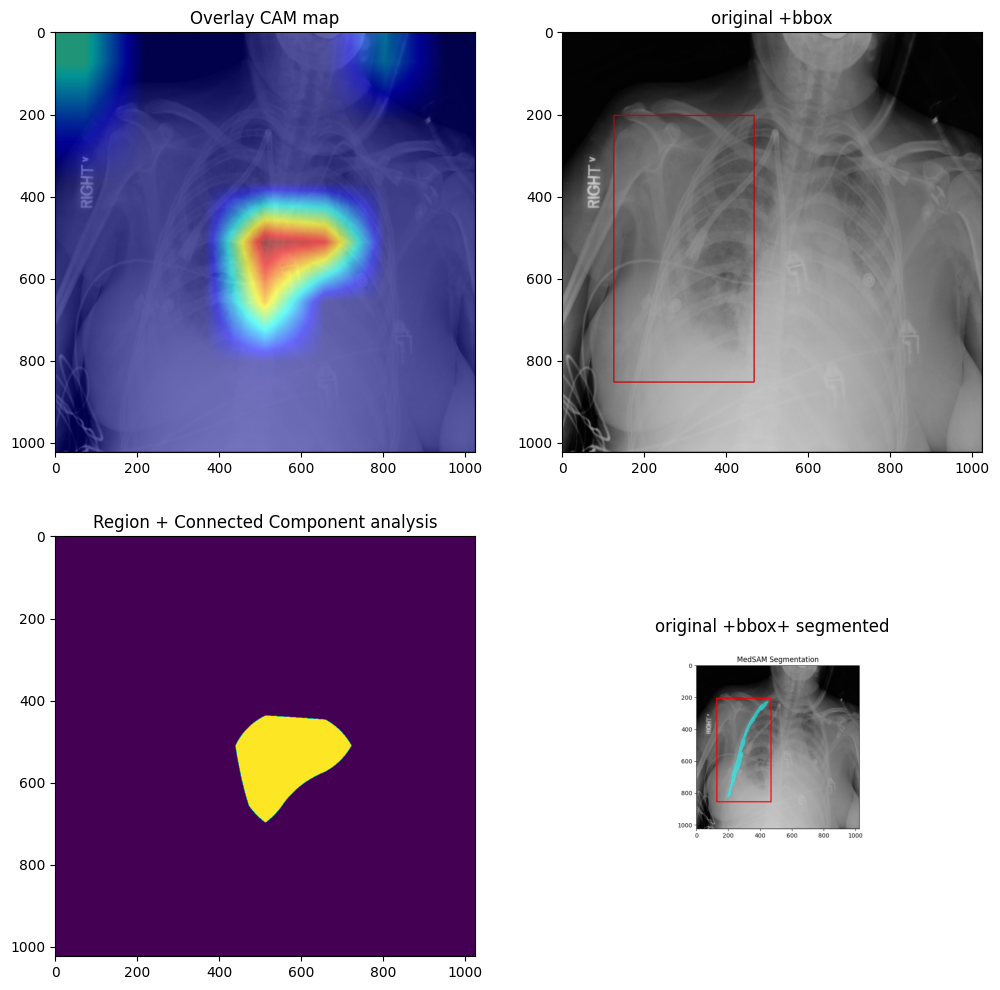

In [34]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget,BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import numpy as np
import matplotlib.pyplot as plt
import cv2

from pprint import pprint




def get_item(index:int=0):
    return next(iter(test_dl))
    

def generate_heatmap(input_tensor,label):
    input_batch = input_tensor[None] #batchify this
    target_layers = [
        model_backbone.resnet[7],
    ]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [BinaryClassifierOutputTarget(int(label))]
    grayscale_cam = cam(input_tensor=input_batch, targets=targets)
    return grayscale_cam[0]


input_tensor, label = get_item(1)

grayscale_cam = generate_heatmap(input_tensor, label)
threshold = 0.5 # adjustable
region = (grayscale_cam > threshold).astype(np.uint8)
analysis = cv2.connectedComponentsWithStats(region, 4, cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
# print(analysis)

# visualization
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax[0][0].imshow(show_cam_on_image(torch.movedim((input_tensor.cpu() *  1.0 / 255.0), 0,2).numpy(), grayscale_cam, use_rgb=True))
ax[0][0].title.set_text("Overlay CAM map")

ax[1][0].imshow(label_ids)
ax[1][0].title.set_text("Region + Connected Component analysis")

img_original=np.transpose(input_tensor.repeat(3,1,1).numpy(),(1, 2, 0))
top_left = (126, 203)
bottom_right = (126 + 342, 203 + 650)
color = (200, 0, 0)  # Rectangle color (BGR format)
thickness = 2
img_with_rect = cv2.rectangle(img_original.copy(), top_left, bottom_right, color, thickness)

ax[0][1].imshow(img_with_rect)
ax[0][1].title.set_text("original +bbox")


img___=cv2.imread("/Users/kunkerdthaisong/intern_cariva/MedSAM/assets/Figure_1.png")

ax[1][1].axis('off'),
ax[1][1].imshow(img___)
ax[1][1].title.set_text("original +bbox+ segmented")



pprint({
    "Component %d" % i : {
        "bounding_box":{
            "x":  values[i, 0],
            "y": values[i,1],
            "width": values[i,2],
            "height" : values[i,3],
        },
        "CM": {
            "x": centroid[i,0],
            "y": centroid[i,1],
        },
        "area": values[i,4],
    }
    for i in range(1, totalLabels)
})

In [40]:
values[1, 0],values[1,1],values[1,2],values[1,3]

(439, 439, 282, 260)

In [28]:
pprint({
    "Component %d" % i : {
        "bounding_box":{
            "x":  values[i, 0],
            "y": values[i,1],
            "width": values[i,2],
            "height" : values[i,3],
        },
        "CM": {
            "x": centroid[i,0],
            "y": centroid[i,1],
        },
        "area": values[i,4],
    }
    for i in range(1, totalLabels)
})

{'Component 1': {'CM': {'x': 800.2960098219767, 'y': 60.985021485573974},
                 'area': 8145,
                 'bounding_box': {'height': 156,
                                  'width': 69,
                                  'x': 765,
                                  'y': 0}},
 'Component 2': {'CM': {'x': 419.7958712864095, 'y': 539.4241069223506},
                 'area': 344175,
                 'bounding_box': {'height': 891,
                                  'width': 1024,
                                  'x': 0,
                                  'y': 133}}}


In [14]:
def generate_heatmap(input_tensor, label):
    model_pre_pcam.eval()
    pcam_head.eval()
    input_batch = input_tensor[None] #batchify this
    h,w=input_batch.shape[-2], input_batch.shape[-1]
    with torch.no_grad():
        pre_pcam_out =  model_pre_pcam(input_batch)
        pcam = pcam_head.get_cam(pre_pcam_out)[:,None,:,:] # [b,1, h', w']
        pcam = F.interpolate(pcam, (h,w), mode='area')[0,0]# h *w

    return pcam.detach().cpu().numpy()

In [57]:
def find_max_area_return_bbox(values):
    j=values[1:,4].argmax()+1
    x=values[j,0]
    y=values[j,1]
    w=values[j,2]
    h=values[j,3]

    return x,y,w,h
    
    
#find_max_area_return_bbox(values=values)

(370, 370, 430, 431)

{'Component 1': {'CM': {'x': 97.45013619854721, 'y': 160.979343220339},
                 'area': 66080,
                 'bounding_box': {'height': 343, 'width': 209, 'x': 0, 'y': 0}},
 'Component 2': {'CM': {'x': 804.0393315926893, 'y': 92.51832898172324},
                 'area': 47875,
                 'bounding_box': {'height': 205,
                                  'width': 263,
                                  'x': 673,
                                  'y': 0}},
 'Component 3': {'CM': {'x': 564.3518665607625, 'y': 563.591954322322},
                 'area': 153598,
                 'bounding_box': {'height': 431,
                                  'width': 430,
                                  'x': 370,
                                  'y': 370}}}


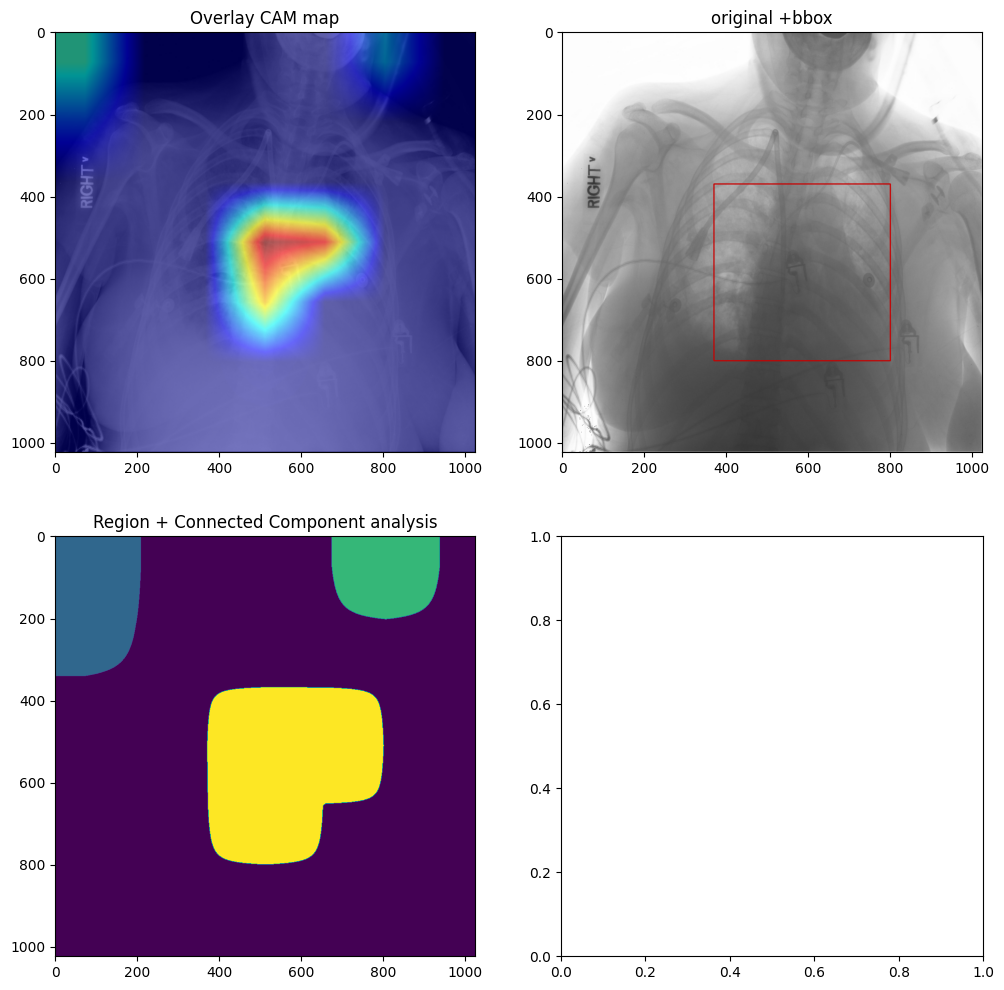

In [59]:
input_tensor, label = get_item(0)
grayscale_cam = generate_heatmap(input_tensor, label)
threshold = 0.03 # adjustable
region = (grayscale_cam > threshold).astype(np.uint8)
analysis = cv2.connectedComponentsWithStats(region,1, cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis


img_rgb = np.repeat(input_tensor, 3, axis=0)
img_rgb = np.transpose(img_rgb, (1, 2, 0))
img_rgb = (img_rgb * 255).numpy().astype(np.uint8)
x,y,w,h=find_max_area_return_bbox(values=values)
img_with_rect = cv2.rectangle(img_rgb.copy(), (x,y), (x + w,y +h), color=(200, 0, 0), thickness=2)

# visualization
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax[0][0].imshow(show_cam_on_image(torch.movedim((input_tensor.cpu() *  1.0 / 255.0), 0,2).numpy(), grayscale_cam, use_rgb=True))
ax[0][0].title.set_text("Overlay CAM map")

ax[1][0].imshow(label_ids)
ax[1][0].title.set_text("Region + Connected Component analysis")

ax[0][1].imshow(img_with_rect)
ax[0][1].title.set_text("original +bbox")



pprint({
    "Component %d" % i : {
        "bounding_box":{
            "x":  values[i, 0],
            "y": values[i,1],
            "width": values[i,2],
            "height" : values[i,3],
        },
        "CM": {
            "x": centroid[i,0],
            "y": centroid[i,1],
        },
        "area": values[i,4],
    }
    for i in range(1, totalLabels)
})


In [52]:
"x":  values[i, 0],
            "y": values[i,1],
            "width": values[i,2],
            "height" : values[i,3],

array([ 66080,  47875, 153598], dtype=int32)

(370, 370, 430, 431)

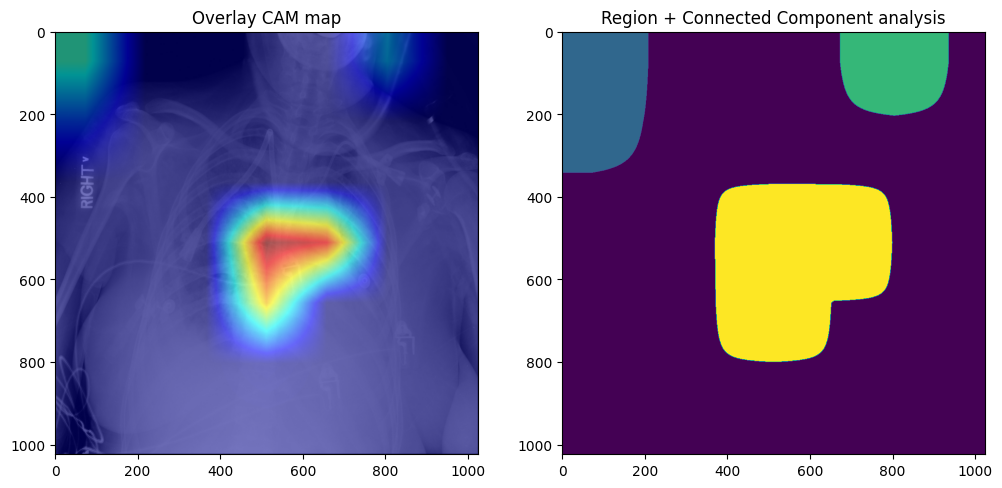

In [42]:
#plot
# visualization
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(show_cam_on_image(torch.movedim((input_tensor.cpu() *  1.0 / 255.0), 0,2).numpy(), grayscale_cam, use_rgb=True))
ax[0].title.set_text("Overlay CAM map")

ax[1].imshow(label_ids)
ax[1].title.set_text("Region + Connected Component analysis")


In [46]:
pydicom.dcmread("./stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm").pixel_array.shape

(1024, 1024)